In [30]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from astropy.table import Column
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import math
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb
import random
from scipy import stats
from scipy.optimize import curve_fit
import scipy.optimize as opt
import statsmodels 
from multiprocessing import Pool
from scipy.signal import find_peaks
from statsmodels.graphics.tsaplots import plot_acf
import glob
import lightkurve as lk
import numpy as np

import glob
import lightkurve as lk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from astropy.table import Table

from lightkurve.correctors import RegressionCorrector
from lightkurve.correctors import DesignMatrix
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import gc
import multiprocessing

# Making Light Curves from a Cluster Catalog

The things that we need from the Cluster Catalog are:
    1. The Cluster Name 
    2. The Cluster Location
    3. The Cluster Radius (In degrees)
    4. The Cluster Age

We also need the path we want to save the finished light curves to

I am going to use the following path throughout:

In [31]:
Path_to_Save_to= '/Users/Tobin/Dropbox/TESS_project/Variability_Statistics/Test_Pipeline_Module/'

Personally, In this folder I have subfolders which may be referenced throughout the rest of the notebook. I will be sure to note when I am using a sub-folder.

Below, I am going to define a function to get the corrected light curve for a given cluster. There are going to be two working functions. One is the one to generate the corrected light curves with an astropy tables which deatils output and cluster information, and the other function is to view and access the lightcurve data. 

The generate function will depend on the callable I want to use for the cluster (i.e name or location). This will be a decision put into the call_type. By default, I have set it to be Name

The Way I have set up the function is to split up specific tasks into individual functions, and then have a final function which combines the steps and if statements to get the results

The First thing we are going to do is see if the Light Curve output table already exists in our Path. Using the output table because even if the lightcurve ins't available or high enough quality, the output table will say so.

In [32]:
def previously_downloaded(Cluster_name):   
    sub_path= 'Corrected_LCs/' #A sub-folder in my Path
    return os.path.exists(Path_to_Save_to+sub_path+str(Cluster_name)+'output_table.fits')

The next thing we want to do is see if TESS has observed the cluster

In [33]:
def tess_data(Callable):
    CLUSTERS = [str(Callable)]

    search = lk.search_tesscut(CLUSTERS[0])#search for the cluster in TESS using lightkurve

    print(CLUSTERS[0]+str(' Has ')+str(len(search))+str(' Observations'))

    if len(search) > 0:
        return True
    else:
        return False 

### Set Up Necessary Functions

#### Conversion Equations

In [34]:
def degs_to_pixels(degs):
    return degs*60*60/21 #convert degrees to arcsecs and then divide by the resolution of TESS (21 arcsec per pixel)

def pixels_to_degs(pixels):
    return pixels*21/(60*60) #convert degrees to arcsecs and then divide by the resolution of TESS (21 arcsec per pixel)

def flux_to_mag(flux):
    m1=10    
    f1=15000    
    mag=2.5*(np.log10(f1/flux)) + m1    
    return mag

def flux_err_to_mag_err(flux, flux_err):
    d_mag_d_flux= -2.5/(flux*np.log(10))

    m_err_squared=(abs(d_mag_d_flux)**2)*(flux_err**2)

    return np.sqrt(m_err_squared)


The following 2 function have been adapted from Vijith to define which pixels in the cluster aperature should be included or excluded in the aperature

These function mark one of the biggest deviations from single star fitting, as we are defining a circle aperature opposed to assignming a flux threshold cut.

In [35]:
def circle_aperture(data,bkg,radius,PERCENTILE):
    radius_in_pixels=degs_to_pixels(radius)
    data_mask = np.zeros_like(data)
    x_len=np.shape(data_mask)[1]
    y_len=np.shape(data_mask)[2]
    #centers
    cen_x=x_len//2
    cen_y=y_len//2
    bkg_mask = np.zeros_like(bkg)
    bkg_cutoff = getUpperLimit(bkg,PERCENTILE)
    for i in range(x_len):
        for j in range(y_len):
            if (i-cen_x)**2+(j-cen_y)**2<(radius_in_pixels)**2:# star mask condition
                data_mask[0,i,j]=1

    x_len=np.shape(bkg_mask)[1]
    y_len=np.shape(bkg_mask)[2]
    cen_x=x_len//2
    cen_y=y_len//2
    for i in range(x_len):
        for j in range(y_len):
            if np.logical_and((i-cen_x)**2+(j-cen_y)**2>(radius_in_pixels)**2, bkg[0,i,j]<bkg_cutoff): # sky mask condition
                bkg_mask[0,i,j]=1            

    star_mask = data_mask==1
    sky_mask = bkg_mask==1

    return star_mask,sky_mask# return masks
    
def getUpperLimit(dataDistribution,PERCENTILE):
    if UPPER_LIMIT_METHOD == 1:
        return np.nanpercentile(dataDistribution, PERCENTILE)

    elif UPPER_LIMIT_METHOD == 2:
        hist = np.histogram(dataDistribution, bins=BINS, range=(0, 3000))# Bin the data
        return hist[1][np.argmax(hist[0])]# Return the flux corresponding to the most populated bin

    elif UPPER_LIMIT_METHOD == 3:
        pass

    elif UPPER_LIMIT_METHOD == 4:
        numMaxima = countMaxima(tpfs[i][frame].flux.reshape((cutout_size, cutout_size)))
        numPixels = np.count_nonzero(~np.isnan(tpfs[i][frame].flux))
        return np.nanpercentile(dataDistribution, 100 - numMaxima / numPixels * 100)

    else:
        return 150
     

These are **choices** which we have adopted. The PERCENTILE limit is particularly important. The cutout size can be adjsuted based on the distance to the clusters we want. For example, extragalactic clusters can have a smaller cutout size to save time. 

In [36]:
UPPER_LIMIT_METHOD = 1
PERCENTILE = 85
cutout_size= 99 #Max for unknown reasons

### Quality Checks

The next phase will be to download the data, perform quality checks and get the uncorrected light curves

Most clusters have more than one observation, we are going to move throught the observations until we find one that passes all of our quality flags.

There are a few scenarios where we will move on from the current observation, and move to the next sector observation.
    1. There is TESS data, but it is unable to be downloaded. (This occurs for a very small number of Sectors, and I don't know why.) 
    
Here is a small test to see if we can download the data:

In [37]:
def downloadable(Callable, current_try_sector):   
    use_name=[Callable]
    #Using a Try statement to see if we can download the cluster data
    try:
        tpfs=lk.search_tesscut(use_name[0])[current_try_sector].download(cutout_size=(cutout_size, cutout_size))
    except:
        print("No Download")
        return 'Bad'

    return 'Fine'


    2. The Cluster is near the edge of the observation. (When this happens, there are nan values in the lightcurve which are unnecessarily hard to deal with, so we will only select clusters that are *not* close to the edges.)
    3. Sector 1 has a known spacecraft systematic, which I haven't been able to correct out of our light curves, so we will ignore this sector)
    
These 3 scenarios are combined into the following test:

In [38]:
def Test_near_edge(tpfs): 

    t1= tpfs[np.where(tpfs.to_lightcurve().quality==0)] #Only selecting time steps that are good, or have quality =0 
    #Also making sure the Sector isn't the one with the Systematic
    if (np.isnan(np.min(t1[0].flux.value)) == False) & (tpfs.sector != 1) & (np.min(t1[0].flux.value) > 1):
        return 'fine'
    else: 
        return 'Bad'

    4. In the Observation, there is significant scatted light which comes from sources not in the cluster. This can be the moon/earth, or a nearby bright star. We calculate this by fitting a model plane to the flux values across the image. If there is scattered light, there will be a gradiant across the image which we quantify by the coefficients of the model plane. 
> * The term *Significant* Is fairly arbitrary. It comes from 27 hand selected observations of 10 clusters, where I plotted the observations that had scattered light vs. the one that didn't, and drew a threshold

In [39]:
def Test_for_Scattered_Light(use_tpfs, full_model_Normalized):
    # regular grid covering the domain of the data
    X,Y = np.meshgrid(np.arange(0, cutout_size, 1), np.arange(0, cutout_size, 1))
    XX = X.flatten()
    YY = Y.flatten()

    #Define the steps for which we test for scattered light 
    time_steps=np.arange(0,len(use_tpfs), 5) #Set the search to be for every 5th time step, can be changed based of the believed frequency of the scattered light

    coefficients_array=np.zeros((len(time_steps), 3))

    data_flux_values=(use_tpfs-full_model_Normalized).flux.value

    for i in range(len(time_steps)):
        data=data_flux_values[time_steps[i]]
        # best-fit linear plane
        A = np.c_[XX, YY, np.ones(XX.shape)]
        C,_,_,_ = scipy.linalg.lstsq(A, data.flatten())    # coefficients
        coefficients_array[i]=C

        #Deleting defined items we don't need any more to save memory
        del A
        del C
        del data

    X_cos= coefficients_array[:,0]
    Y_cos= coefficients_array[:,1]
    Z_cos= coefficients_array[:,2]

    mxc=max(abs(X_cos))
    myc=max(abs(Y_cos))
    mzc=max(abs(Z_cos))

    #Deleting defined items we don't need any more to save memory
    del X_cos
    del Y_cos
    del Z_cos
    del coefficients_array
    gc.collect() #This is a command which will delete stray arguments to save memory

    if (mzc > 1.0) | ((mxc > 0.02) & (myc > 0.02)): 
        return 'Bad'
    else:
        return 'Fine'

## Correct the Light Curve

#### At the same time, move through Observations until we find one that passes each quality flag

This function is going to combine many of the previous functions

The following function and corrections steps adapt certain decisions, but generlly follow the tutorial given here: https://tessgi.github.io/tess-case-studies/notebooks/pixel-level-detrending/ 

In [49]:
def Get_LCs(Callable, Radius, Cluster_name):
    # Knowing how many observations we have to work with
    search = lk.search_tesscut(Callable)
    sectors_available=len(search)
    
    #We are also going to doccument how many observations failed each one of our quality tests
    failed_download=0
    near_edge_or_Sector_1=0
    Scattered_Light=0
    good_obs=0
    which_sectors_good=[]
    LC_lens=[]
    
    #start interating through the observations       
    for current_try_sector in range(sectors_available):
        print("Starting Quality Tests for Observation:", current_try_sector)

        #First is the Download Test
        if (downloadable(Callable, current_try_sector)== 'Bad') & (current_try_sector+1 < sectors_available):
            print('Failed Download')
            failed_download=failed_download+1
            continue
        if (downloadable(Callable, current_try_sector)== 'Bad') & (current_try_sector+1 < sectors_available):
            print('Failed Download')
            failed_download=failed_download+1
            return ['No Good Observations'], np.array(int(sectors_available)), np.array(which_sectors_good), np.array(int(failed_download)), np.array(int(near_edge_or_Sector_1)), np.array(int(Scattered_Light)), 0
        else:
            use_name=[Callable]
            tpfs=tpfs=lk.search_tesscut(use_name[0])[current_try_sector].download(cutout_size=(cutout_size, cutout_size))
        
        #Now Edge Test
        
        if (Test_near_edge(tpfs) == 'Bad') & (current_try_sector+1 < sectors_available):
            print('Failed Near Edge Test')
            near_edge_or_Sector_1=near_edge_or_Sector_1+1
            continue
        if (Test_near_edge(tpfs) == 'Bad') & (current_try_sector+1 == sectors_available):
            print('Failed Near Edge Test') 
            near_edge_or_Sector_1=near_edge_or_Sector_1+1
            return ['No Good Observations'], np.array(int(sectors_available)),  np.array(which_sectors_good), np.array(int(failed_download)), np.array(int(near_edge_or_Sector_1)), np.array(int(Scattered_Light)), 0
        else: 
            use_tpfs = tpfs[np.where(tpfs.to_lightcurve().quality==0)]

        #Getting Rid of where the flux err < 0
        use_tpfs = use_tpfs[use_tpfs.to_lightcurve().flux_err>0]

        #Define the aperature for our Cluster based on previous Vijith functions
        star_mask1=np.empty([len(use_tpfs),cutout_size,cutout_size],dtype='bool')
        sky_mask1=np.empty([len(use_tpfs),cutout_size,cutout_size],dtype='bool')

        star_mask1[0],sky_mask1[0] = circle_aperture(use_tpfs[0].flux.value, use_tpfs[0].flux.value, Radius, PERCENTILE)

        keep_mask=star_mask1[0]
        
        #This will print an image of the cluster with the used aperature shown in red
        p = use_tpfs.plot(frame=use_tpfs.shape[0] // 2, aperture_mask=keep_mask)
        
        #Now we will begin to correct the lightcurve
        
        uncorrected_lc = use_tpfs.to_lightcurve(aperture_mask=keep_mask)

        # Time average of the pixels in the TPF:
        max_frame = use_tpfs.flux.value.max(axis=0)
        # This renormalizes any columns which are bright because of straps on the detector
        max_frame -= np.median(max_frame, axis=0)
        # This aperture is any "faint" pixels:
        bkg_aper = max_frame < np.percentile(max_frame, PERCENTILE)
        # The average light curve of the faint pixels is a good estimate of the scattered light
        scattered_light = use_tpfs.flux.value[:, bkg_aper].mean(axis=1)

        #We can use our background aperture to create pixel time series and then take Principal Components of the data using Singular Value Decomposition. This gives us the "top" trends that are present in the background data.
        # I have picked 6 based on previous studies showing that is an abritrarily optimal number of components
        pca_dm1 = lk.DesignMatrix(use_tpfs.flux.value[:, bkg_aper], name='PCA').pca(6) 
        #Here we are going to set the priors for the PCA to be located around the flux values of the uncorected LC
        pca_dm1.prior_mu =np.array([np.median(uncorrected_lc.flux.value) for i in range(6)])
        pca_dm1.prior_sigma =np.array([(np.percentile(uncorrected_lc.flux.value, 84) - np.percentile(uncorrected_lc.flux.value, 16)) for i in range(6)])

        #The TESS mission pipeline provides cotrending basis vectors (CBVs) which capture common trends in the dataset. We can use these to detrend out pixel level data.
        #The mission provides MultiScale CBVs, which are at different time scales. In this case, we don't want to use the long scale CBVs, because this may fit out real astrophysical variability. Instead we will use the medium and short time scale CBVs.
        
        cbvs_1 = lk.correctors.cbvcorrector.download_tess_cbvs(sector=use_tpfs.sector, camera=use_tpfs.camera, ccd=use_tpfs.ccd, cbv_type='MultiScale', band=2).interpolate(use_tpfs.to_lightcurve())
        cbvs_2 = lk.correctors.cbvcorrector.download_tess_cbvs(sector=use_tpfs.sector, camera=use_tpfs.camera, ccd=use_tpfs.ccd, cbv_type='MultiScale', band=3).interpolate(use_tpfs.to_lightcurve())


        cbv_dm1 = cbvs_1.to_designmatrix(cbv_indices=np.arange(1, 8))
        cbv_dm2 = cbvs_2.to_designmatrix(cbv_indices=np.arange(1, 8))

        # This combines the different timescale CBVs into a single `designmatrix` object
        cbv_dm_use = lk.DesignMatrixCollection([cbv_dm1, cbv_dm2]).to_designmatrix()
        
        # We can make a simple basis-spline (b-spline) model for astrophysical variability. This will be a flexible, smooth model.
        # The number of knots is important, we want to only correct for very long term variabilty that looks like systematics, so here we have 5 knots, the smaller the better
        spline_dm1 = lk.designmatrix.create_spline_matrix(use_tpfs.time.value, n_knots=5)

        
        # Here we create our design matrix

        dm1 = lk.DesignMatrixCollection([pca_dm1,
                                         cbv_dm_use,
                                         spline_dm1,
                                         ])


        full_model, systematics_model, full_model_Normalized = np.ones((3, *use_tpfs.shape))
        for idx in tqdm(range(use_tpfs.shape[1])):
            for jdx in range(use_tpfs.shape[2]):
                pixel_lightcurve = lk.LightCurve(time=use_tpfs.time.value, flux=use_tpfs.flux.value[:, idx, jdx], flux_err=use_tpfs.flux_err.value[:, idx, jdx])

                #Adding a test to make sure ther are No Flux_err's <= 0
                pixel_lightcurve=pixel_lightcurve[pixel_lightcurve.flux_err > 0]

                r1 = lk.RegressionCorrector(pixel_lightcurve)
                # Correct the pixel light curve by our design matrix
                r1.correct(dm1)
                # Extract just the systematics components
                systematics_model[:, idx, jdx] = (r1.diagnostic_lightcurves['PCA'].flux.value +
                                                  r1.diagnostic_lightcurves['CBVs'].flux.value)
                # Add all the components
                full_model[:, idx, jdx] =  (r1.diagnostic_lightcurves['PCA'].flux.value +
                                            
                                            r1.diagnostic_lightcurves['CBVs'].flux.value +

                                            r1.diagnostic_lightcurves['spline'].flux.value)

                #Making so the model isn't centered around 0
                full_model[:, idx, jdx] -= r1.diagnostic_lightcurves['spline'].flux.value.mean()


                #Making Normalized Model For the Test of Scattered Light
                full_model_Normalized[:, idx, jdx] =  (r1.diagnostic_lightcurves['PCA'].flux.value +
                                                       
                                                       r1.diagnostic_lightcurves['CBVs'].flux.value +

                                                       r1.diagnostic_lightcurves['spline'].flux.value)                       

        #Calculate Lightcurves
#NOTE- we are also calculating a lightcurve which does not include the spline model, this is the systematics_model_corrected_lightcurve1
        scattered_light_model_correected_lightcurve=(use_tpfs - scattered_light[:, None, None]).to_lightcurve(aperture_mask=keep_mask)
        systematics_model_corrected_lightcurve=(use_tpfs - systematics_model).to_lightcurve(aperture_mask=keep_mask)
        full_corrected_lightcurve=(use_tpfs - full_model).to_lightcurve(aperture_mask=keep_mask)

        full_corrected_lightcurve_table=Table([full_corrected_lightcurve.time.value, 
                                                full_corrected_lightcurve.flux.value,
                                                full_corrected_lightcurve.flux_err.value], 
                                                names=('time', 'flux', 'flux_err'))


        if (Test_for_Scattered_Light(use_tpfs, full_model_Normalized) == 'Bad') & (current_try_sector+1 < sectors_available):
            print("Failed Scattered Light Test")
            Scattered_Light=Scattered_Light+1
            continue
        if (Test_for_Scattered_Light(use_tpfs, full_model_Normalized) == 'Bad') & (current_try_sector+1 == sectors_available):
            print("Failed Scattered Light Test")
            Scattered_Light=Scattered_Light+1
            return ['No Good Observations'], np.array(int(sectors_available)), np.array(which_sectors_good), np.array(int(failed_download)), np.array(int(near_edge_or_Sector_1)), np.array(int(Scattered_Light)), 0
        else:
            print(current_try_sector, "Passed Quality Tests")
            good_obs+1
            which_sectors_good.append(i)
            #This Else Statement means that the Lightcurve is good and has passed our quality checks
            
            #Writting out the data, so I never have to Download and Correct again, but only if there is data
            full_corrected_lightcurve_table.add_column(Column(flux_to_mag(full_corrected_lightcurve_table['flux'])), name='mag')
            full_corrected_lightcurve_table.add_column(Column(flux_err_to_mag_err(full_corrected_lightcurve_table['flux'], full_corrected_lightcurve_table['flux_err'])), name='mag_err')
            
            lc_path="Corrected_LCs/"        
            full_corrected_lightcurve_table.write(Path_to_Save_to+lc_path+str(Cluster_name)+'.fits', format='fits', append=True)
            
            #Now I am going to save a plot of the light curve to go visually inspect later
            range_=max(full_corrected_lightcurve_table['flux'])-min(full_corrected_lightcurve_table['flux'])
            fig=plt.figure()
            plt.title('Observation:'+str(current_try_sector))
            plt.plot(full_corrected_lightcurve_table['time'], full_corrected_lightcurve_table['flux'], color='k', linewidth=.5)
            plt.xlabel('Delta Time [Days]')
            plt.ylabel('Flux [e/s]')
            plt.text(full_corrected_lightcurve_table['time'][0], (max(full_corrected_lightcurve_table['flux'])-(range_*0.05)), str(Cluster_name), fontsize=14)
            plt.subplots_adjust(right=1.4, top=1)

            path="Figures/LCs/" #Sub-folder 
            which_fig="_Full_Corrected_LC_"
            sector="Observation_"+str(current_try_sector)
            out=".png"

            plt.savefig(Path_to_Save_to+path+str(Cluster_name)+which_fig+sector+out, format='png') 
            plt.close(fig) 

            LC_lens.append(len(full_corrected_lightcurve_table))
    
    return np.array(int(sectors_available)), np.array(int(good_obs)), np.array(which_sectors_good), np.array(int(failed_download)), np.array(int(near_edge_or_Sector_1)), np.array(int(Scattered_Light)), np.array(LC_lens)




## Put it All Together

In [52]:
def Generate_Lightcurves(Cluster_name, Location, Radius, Cluster_Age, call_type_Name=True):
    
    #Setting which collable we want to use
    if call_type_Name:
        Callable= Cluster_name
    else:
        Callable= Location
        
    if tess_data(Callable) == True:
        #Test to see if I have already downloaded and corrected this cluster, If I have, read in the data
        if previously_downloaded(Cluster_name) == True:
            output_table= Table.read(Path_to_Save_to+'Corrected_LCs/'+str(Cluster_name)+'output_table.fits', hdu=1)

            return output_table
        
        else: # This else statement refers to the Cluster Not Previously Being Downloaded          
              # So Calling funcion to download and correct data
            Good_observations, Obs_Available, WhichOnes_Good, Obs_failed_download, Obs_near_Edge, Obs_Scattered_Light, LC_lens = Get_LCs(Callable, Radius, Cluster_name)
        
        # Now that I have my data, if it is a light curve, I'm going to make the figure, and 
        if Good_observations[0] != 'No Good Observations':

            #Making the Output Table
            name___=[Cluster_name]
            HTD=[True]
            OB_use=[Good_observations]
            OB_av=[Obs_Available]
            OB_good=[str(WhichOnes_Good)]
            OB_fd=[Obs_failed_download]
            OB_ne=[Obs_near_Edge]
            OB_sl=[Obs_Scattered_Light]
            OB_lens=str((LC_lens))


            output_table=Table([name___, [Location], [Radius], [Cluster_Age], HTD, OB_av, OB_use, OB_good, OB_fd, OB_ne, OB_sl, OB_lens],
                               names=('Name', 'Location', 'Radius [deg]', 'Log Age', 'Has_TESS_Data', 'Obs_Available',
                                      'Num_Good_Obs', 'Which_Obs_Good', 'Obs_DL_Failed', 'Obs_Near_Edge_S1', 'Obs_Scattered_Light', 'Light_Curve_Lengths'))

            #Writting out the data, so I never have to Download and Correct again, but only if there is data
            lc_path="Corrected_LCs/"        

            output_table.write(Path_to_Save_to+lc_path+str(Cluster_name)+'output_table.fits')

            #now I'm going to read in the lightcurves and attach them to the outfpu table to have all data in one place
            for i in range(output_table['Good_Obs'][0]):
                light_curve_table=Table.read(Path_to_Save_to+lc_path+str(Cluster_name)+'.fits', hdu=i+1)
                light_curve_table.write(Path_to_Save_to+lc_path+str(Cluster_name)+'output_table.fits', append=True)
            
            return output_table
                
            
        else: #This else statement refers to there being No good Observtions

            Good_observations= -99

            name___=[Cluster_name]
            HTD=[True]
            OB_use=[Good_observations]
            OB_av=[Obs_Available]
            OB_good=[str(WhichOnes_Good)]
            OB_fd=[Obs_failed_download]
            OB_ne=[Obs_near_Edge]
            OB_sl=[Obs_Scattered_Light]
            OB_lens=str((LC_lens))


            output_table=Table([name___, [Location], [Radius], [Cluster_Age], HTD, OB_av, OB_use, OB_good, OB_fd, OB_ne, OB_sl, OB_lens],
                               names=('Name', 'Location', 'Radius [deg]', 'Log Age', 'Has_TESS_Data', 'Obs_Available',
                                      'Num_Good_Obs', 'Which_Obs_Good', 'Obs_DL_Failed', 'Obs_Near_Edge_S1', 'Obs_Scattered_Light', 'Light_Curve_Lengths'))
            
            output_table.write(Path_to_Save_to+"Corrected_LCs/"+str(Cluster_name)+'output_table.fits')
            
            return output_table 
          
    else: #This Means that there is no TESS coverage for the Cluster (Easiest to check)
        name___= [Cluster_name]       
        HTD=[False]  
        OB_use= np.ma.array([0], mask=[1])
        OB_good= np.ma.array([0], mask=[1])
        OB_av= np.ma.array([0], mask=[1])
        OB_fd= np.ma.array([0], mask=[1])
        OB_ne= np.ma.array([0], mask=[1])
        OB_sl= np.ma.array([0], mask=[1])  
        OB_lens= np.ma.array([0], mask=[1])

        output_table=Table([name___, [Location], [Radius], [Cluster_Age], HTD, OB_av, OB_use, [str(OB_good)], OB_fd, OB_ne, OB_sl, [str(OB_lens)]],
                           names=('Name', 'Location', 'Radius [deg]', 'Log Age', 'Has_TESS_Data', 'Obs_Available',
                                  'Num_Good_Obs', 'Which_Obs_Good', 'Obs_DL_Failed', 'Obs_Near_Edge_S1', 'Obs_Scattered_Light', 'Light_Curve_Lengths'))

        output_table.write(Path_to_Save_to+"Corrected_LCs/"+str(Cluster_name)+'output_table.fits', overwrite=True)

        return output_table 
        
        

## Data Access

This function does not view the lightcurve at all. So if we want to get our hands on the data we need to know which observation want to look at. This will require knowing how many observations from a given cluster have available light curves. Therefore, before running this function, we must already have the light curve corrected and saved.


In [53]:
def Access_Lightcurve(Cluster_name, desired_observation):
    try:
        output_table= Table.read(Path_to_Save_to+'Corrected_LCs/'+str(Cluster_name)+'output_table.fits', hdu=1)
    except:
        raise Exception("The Lightcurve has not been downloaded and corrected. Please run 'Generate_Lightcurves()' function for this cluster.")

    #Get the Light Curve
    light_curve_table= Table.read(Path_to_Save_to+'Corrected_LCs/'+str(Cluster_name)+'output_table.fits', hdu=desired_observation)
    
    sector_number=output_table['Which_Obs_Good'][desired_observation]
    #Retrive the figure
    path="Figures/LCs/" #Sub-folder 
    which_fig="_Full_Corrected_LC_"
    sector="Observation_"+str(sector_number)
    out=".png"
    
    img = plt.imread(Path_to_Save_to+path+str(Cluster_name)+which_fig+sector+out)
    fig = plt.figure()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.close()
    
    return fig, light_curve_table
    
        

## Example 

In [ ]:
Generate_Lightcurves(Cluster_name='NGC 419', Location='23.58271, +61.1236', Radius=.046, Cluster_Age=7.75)

NGC 419 Has 4 Observations
Starting Quality Tests for Observation: 0
Failed Near Edge Test
Starting Quality Tests for Observation: 1
Failed Near Edge Test
Starting Quality Tests for Observation: 2


 20%|██        | 20/99 [05:44<22:10, 16.84s/it]

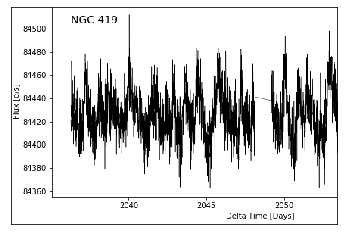

In [48]:
Access_Lightcurve(Cluster_name='NGC 419', desired_observation=2)[0]